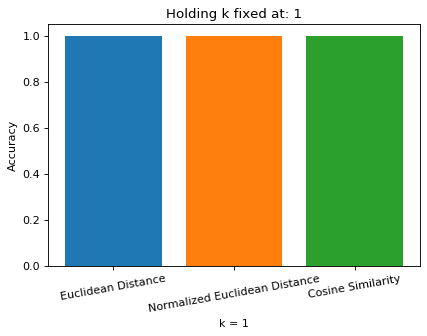

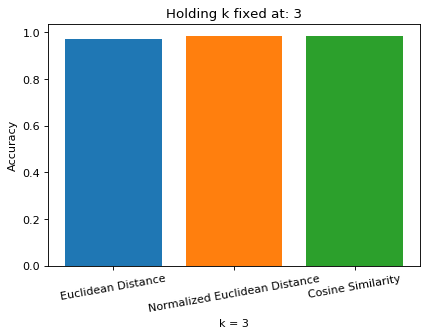

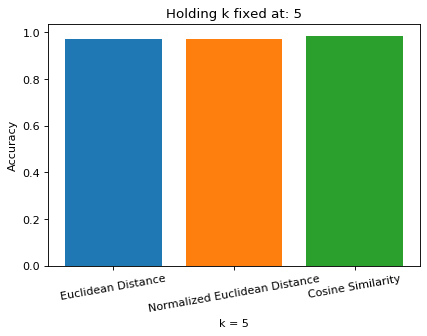

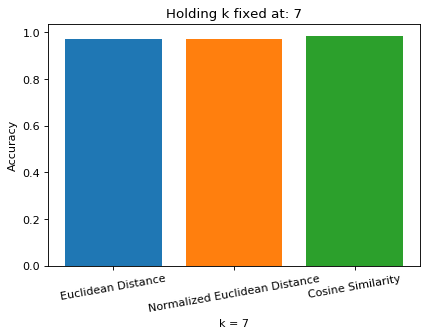

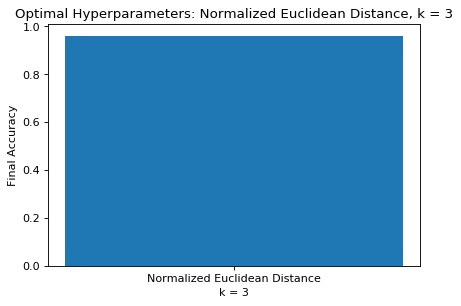

In [86]:
from sys import path, exit

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection




def Get_Iris_Development_andTest_Data(iris_data_path, test_percentage=0.5):
    
    iris_data_df = pd.read_csv(iris_data_path)
    iris_data_df.columns = ['sepal length in cm', 'sepal width in cm', 'petal length in cm', 'petal width in cm', 'class']
    
    #print(iris_data_df)
    
    # shuffles the dataframe & resets the its index
    iris_data_df = iris_data_df.sample(frac=1).reset_index(drop=True)
    #print(iris_data_df)
    
    flower_names = list(set(iris_data_df.iloc[:, -1]))
    for id, name in enumerate(flower_names): iris_data_df['class'] = iris_data_df['class'].str.replace(name, str(id))
    iris_data_df['class'] = pd.to_numeric(iris_data_df['class'])
    
    # shuffles the dataframe & resets the its index
    iris_data_df = iris_data_df.sample(frac=1).reset_index(drop=True)
    
    development, test = sklearn.model_selection.train_test_split(iris_data_df, test_size=test_percentage)
    
    # shuffles the dataframe & resets the its index
    development = development.sample(frac=1).reset_index(drop=True)
    
    # shuffles the dataframe & resets the its index
    test = test.sample(frac=1).reset_index(drop=True)
    
    development = development.values
    test = test.values
    
    #print(development)
    
    return development, test




class kNN_Classifier:
    
    def __init__(self):
        
        self.labled_records = None
        self.optimal_hyperparameters = None
        
        def Get_Record(Record_Matrix, record_number):
            row = Record_Matrix[record_number, :]
            record = row.reshape(1, row.shape[0])
            return record
        self.Get_Record = Get_Record

        def Split_Record_fromClass(record):
            records_class = record[0][-1]
            record = record[:, :-1]
            return record, records_class
        self.Split_Record_fromClass = Split_Record_fromClass
        
        def Get_Configs():
            distance_metrics = ['Euclidean Distance', 'Normalized Euclidean Distance', 'Cosine Similarity']
            k_values = [1, 3, 5, 7]
            
            configs = []
            for i in distance_metrics:
                for j in k_values:
                    config = [i, j]
                    configs.append(config)
            return configs
        self.Get_Configs = Get_Configs
        
        return

    
    
    def Calculate_Distance(self, distance_metric, record1, record2):
    
        if distance_metric.lower() == 'Euclidean Distance'.lower():
            measure = scipy.spatial.distance.euclidean(record1, record2)
            
        elif distance_metric.lower() == 'Normalized Euclidean Distance'.lower():
            record1_average = np.average(record1)
            record2_average = np.average(record2)
            numerator = (np.linalg.norm((record1 - record1_average) - (record2 - record2_average)))**2
            denominator = (2*(((np.linalg.norm(record1 - record1_average))**2) + ((np.linalg.norm(record2 - record2_average))**2)))
            measure = numerator / denominator
        
        elif distance_metric.lower() == 'Cosine Similarity'.lower():
            measure = scipy.spatial.distance.cosine(record1, record2)
    
        return measure

    
    
    def Compute_Distances_toOtherRecords(self, distance_metric, unknown_record):
        
        distances = []
        for i in range(self.labled_records.shape[0]):
            labled_record_i = self.Get_Record(self.labled_records, i)
               
            record_i = self.Split_Record_fromClass(labled_record_i)[0]
            distance = self.Calculate_Distance(distance_metric, record_i, unknown_record)
            
            distances.append((distance, labled_record_i))
                
        return distances



    def Identify_kNNs(self, k, distances):
    
        distances.sort(key = lambda x: x[0])
        
        #print(distances)
        
        NNs = distances[:k]
        for index, nn in enumerate(NNs): NNs[index] = nn[1][0][:]
    
        return NNs



    def Determine_ClassLabel_ofUnknownRecord(self, kNNs):
    
        votes = {}
        for knn in kNNs:
            if knn[-1] not in votes.keys(): votes[knn[-1]] = 1
            else: votes[knn[-1]] += 1
                
        votes = [(vote, votes[vote]) for vote in votes]
        majority_vote = max(votes, key=lambda x: x[1])[0]
        
        return majority_vote

    
    
    def Classify_UnknownRecord(self, distance_metric, k, unknown_record):
        
        distances = self.Compute_Distances_toOtherRecords(distance_metric, unknown_record)
        kNNs = self.Identify_kNNs(k, distances)        
        classified_label = self.Determine_ClassLabel_ofUnknownRecord(kNNs)
    
        return classified_label
    
    
    
    def Score_Config(self, config, test_records=None):
        
        if isinstance(test_records, np.ndarray) == False: test_records = self.labled_records.copy()
    
        distance_metric, k = config; correct_count = 0
        for i in range(test_records.shape[0]):
            
            test_record_i = self.Get_Record(test_records, i)
            unknown_record, actual_class_label = self.Split_Record_fromClass(test_record_i)
            
            classified_label = self.Classify_UnknownRecord(distance_metric, k, unknown_record)

            if classified_label == actual_class_label: correct_count += 1
        
        score = correct_count / test_records.shape[0]
    
        return score
    
    
    
    def Train(self, labled_records):
        self.labled_records = labled_records.copy()
    
        configs = self.Get_Configs()
        results = [(self.Score_Config(config), config) for config in configs]
        self.ShowAccuracy(results)
    
        results.sort(key=lambda x: x[0], reverse=True)
        #print('\nresults:\n', results)
        #print('\nresults count: ', len(results))
        #print('\n record count: ', self.labled_records.shape[0])
        optimal_hyperparameters = results.pop(0)[1]
        while optimal_hyperparameters[1] == 1: optimal_hyperparameters = results.pop(0)[1]
    
        self.optimal_hyperparameters = optimal_hyperparameters
        
        #print('\nself.optimal_hyperparameters: ', self.optimal_hyperparameters)
        
        return

    
    
    def ShowAccuracy(self, results):
        
        if isinstance(results, list) == False:
            test_records = results
            results = [(self.Score_Config(self.optimal_hyperparameters, test_records), self.optimal_hyperparameters)]
    
        #print(results)
    
        bins = {}
        for result in results:
            k = result[1][1]
            if k not in bins: bins[k] = [result]
            else: bins[k].append(result)
    
        k_values = list(bins.keys())
        for k in k_values:
        
            figure = plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k').add_subplot()        
            figure.set_xlabel('k = ' + str(k))
        
            dms = []
            for element in bins[k]:
                score = element[0]
                dm = element[1][0]
                dms.append(dm)
                plt.bar(dm, score)
        
            if len(k_values) > 1:
                figure.set_xticklabels(dms, rotation=10)     
                figure.set_title('Holding k fixed at: ' + str(k))
                figure.set_ylabel('Accuracy')
        
            if len(k_values) == 1:
                figure.set_title('Optimal Hyperparameters: ' + dms[0] + ', k = ' + str(k))
                figure.set_ylabel('Final Accuracy')
        
        return




iris_data_path = path[0] + '/data/iris.data'
development_data, test_data = Get_Iris_Development_andTest_Data(iris_data_path)

knn_classifier = kNN_Classifier()
knn_classifier.Train(development_data)
knn_classifier.ShowAccuracy(test_data)

plt.show()
